In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/vanilla_dropout.h5'
modeloSave='/transfer_vanilla_dropout_completo.h5'

In [5]:
balanceo=''

In [6]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

In [7]:
paciente='paciente2'

In [8]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [9]:
len(array_Xtrain)

13931

In [10]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [11]:
len(array_Ytrain)

13931

In [12]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [13]:
len(array_Xval)

1741

In [14]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [15]:
len(array_Yval)

1741

In [16]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [17]:
len(array_Xtest)

1742

In [18]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [19]:
len(array_Ytest)

1742

In [20]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [21]:
base_model = keras.models.load_model(modeloBasePath)

55/55 [==============================] - 1s 10ms/step


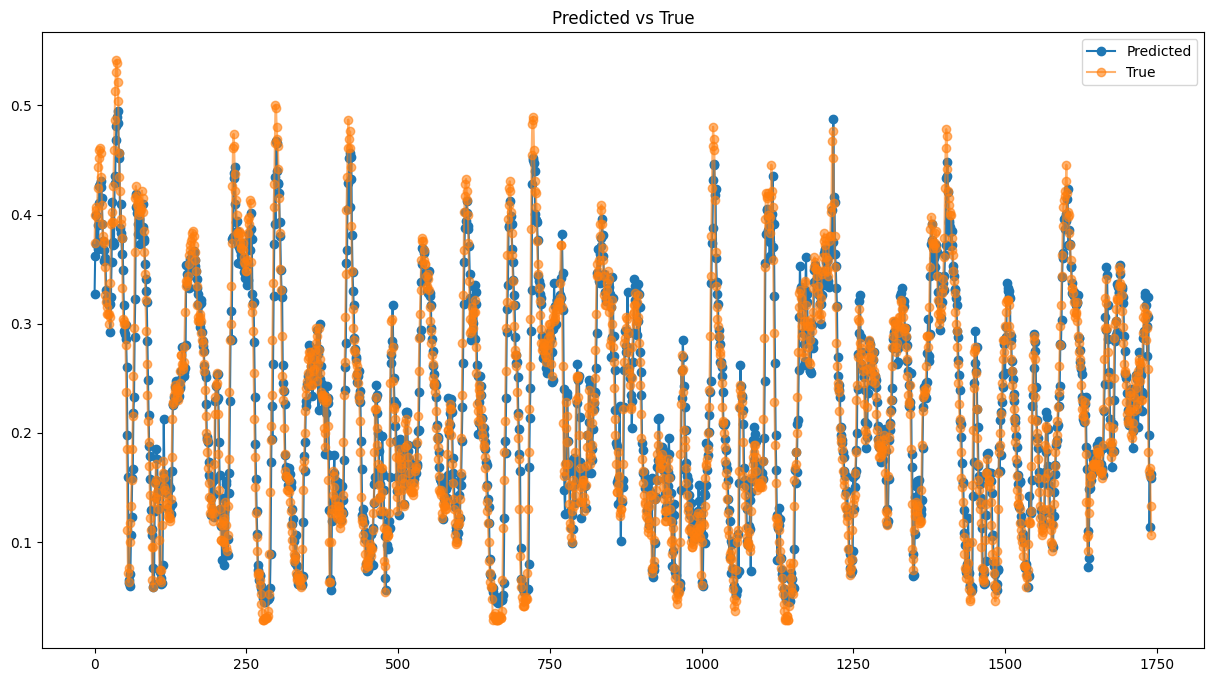

In [22]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [23]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.022967179749626455,
 'mse': 0.02998608648691033,
 'rmse': 0.0008991653828004663}

# Iniciamos transfer learning

In [24]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [25]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [26]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-2,False,True)
transferModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [27]:
array_Xtrain.shape

(13931, 30, 5)

In [28]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
436/436 [==============================] - 9s 13ms/step - loss: 0.0043 - mae: 0.0375 - mse: 0.0043 - val_loss: 0.0013 - val_mae: 0.0287 - val_mse: 0.0013
Epoch 2/100
436/436 [==============================] - 7s 16ms/step - loss: 8.1032e-04 - mae: 0.0199 - mse: 8.1032e-04 - val_loss: 0.0013 - val_mae: 0.0288 - val_mse: 0.0013
Epoch 3/100
436/436 [==============================] - 5s 12ms/step - loss: 7.4039e-04 - mae: 0.0189 - mse: 7.4039e-04 - val_loss: 0.0012 - val_mae: 0.0276 - val_mse: 0.0012
Epoch 4/100
436/436 [==============================] - 6s 14ms/step - loss: 7.2904e-04 - mae: 0.0189 - mse: 7.2904e-04 - val_loss: 0.0013 - val_mae: 0.0285 - val_mse: 0.0013
Epoch 5/100
436/436 [==============================] - 7s 16ms/step - loss: 7.1428e-04 - mae: 0.0185 - mse: 7.1428e-04 - val_loss: 0.0012 - val_mae: 0.0272 - val_mse: 0.0012
Epoch 6/100
436/436 [==============================] - 5s 12ms/step - loss: 7.0139e-04 - mae: 0.0184 - mse: 7.0139e-04 - val_loss: 0.0011 

55/55 [==============================] - 1s 11ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012
test loss, test acc: [0.0011513796634972095, 0.02702377177774906, 0.0011513796634972095]


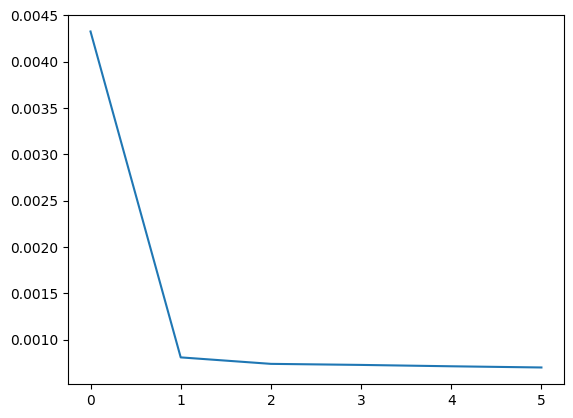

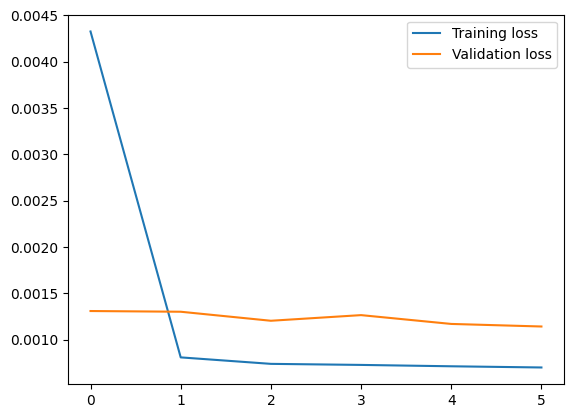

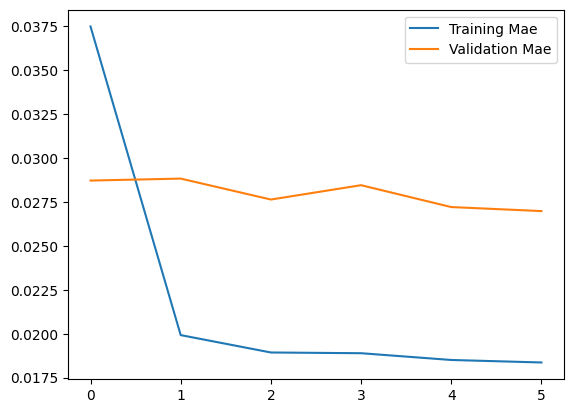

In [29]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

55/55 [==============================] - 1s 10ms/step


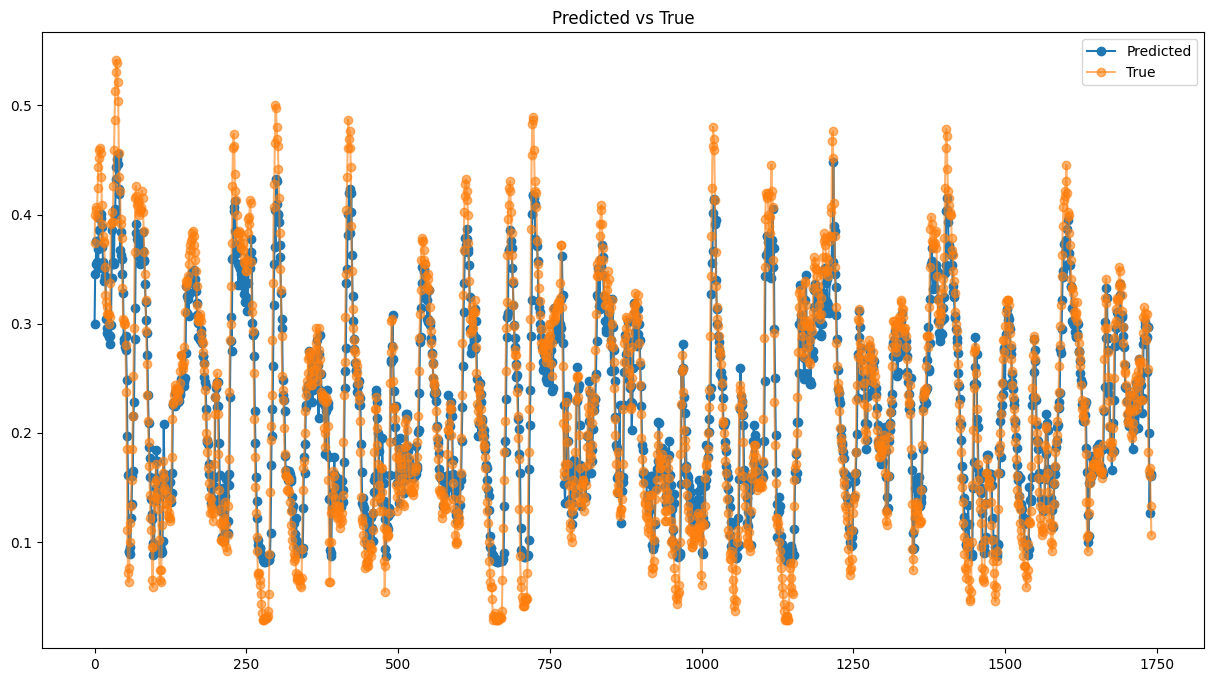

In [30]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.027023774728430143,
 'mse': 0.03393198497707562,
 'rmse': 0.0011513796044844856}

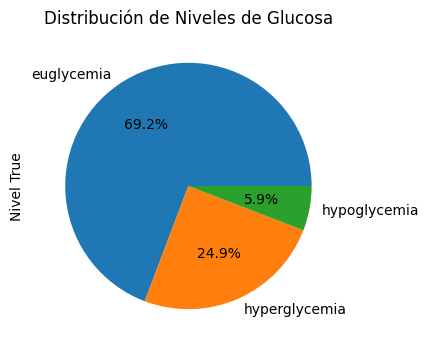

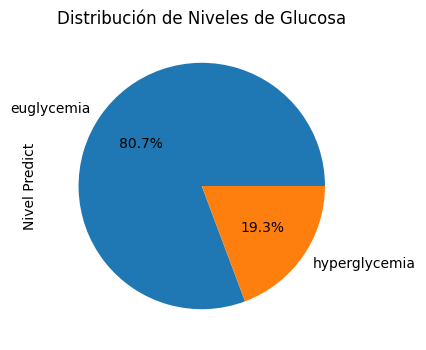

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,212.0,hyperglycemia,178.056442,euglycemia
1,224.0,hyperglycemia,198.765869,hyperglycemia
2,226.0,hyperglycemia,203.248947,hyperglycemia
3,227.0,hyperglycemia,212.886749,hyperglycemia
4,223.0,hyperglycemia,203.972595,hyperglycemia


In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


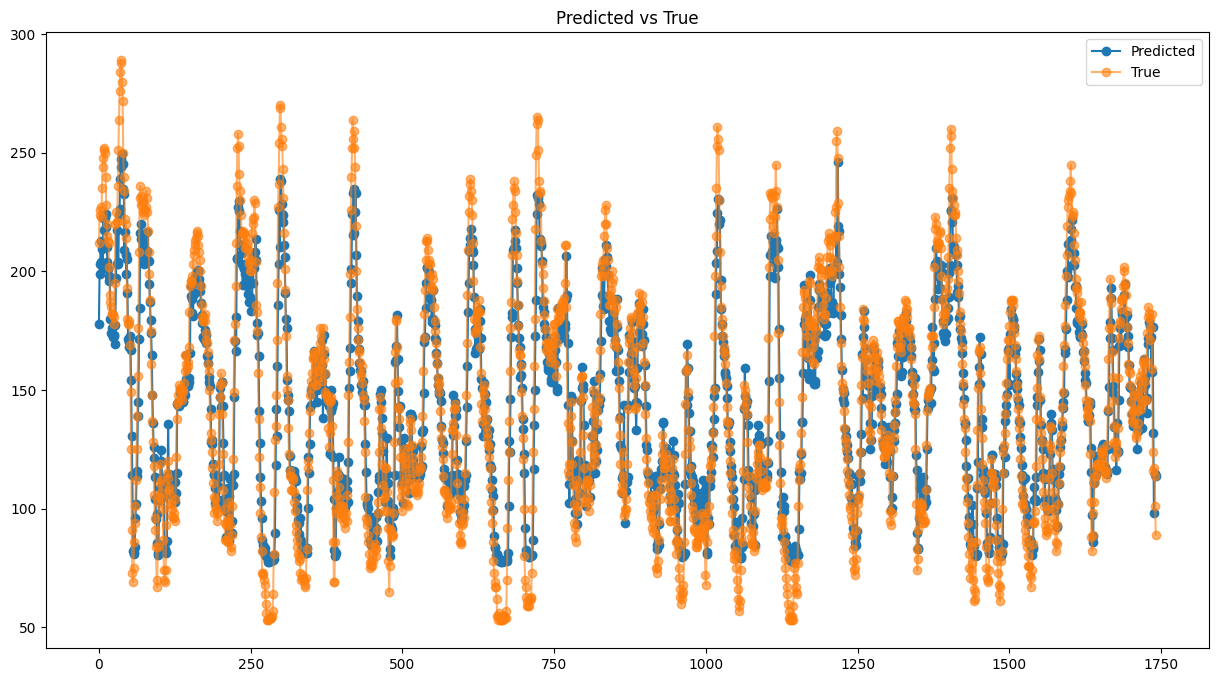

{'mae': 12.430935137836677,
 'mse': 15.608711890144813,
 'rmse': 243.63188686954805}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,212.0,178.056442
2023-01-01 00:15:00,224.0,198.765869
2023-01-01 00:30:00,226.0,203.248947
2023-01-01 00:45:00,227.0,212.886749
2023-01-01 01:00:00,223.0,203.972595
...,...,...
2023-01-19 02:15:00,116.0,131.740860
2023-01-19 02:30:00,117.0,98.186012
2023-01-19 02:45:00,114.0,114.735367
2023-01-19 03:00:00,101.0,114.568222


AP, BE, EP: (0.9270534175761057, 0.016082711085583, 0.05686387133831131)


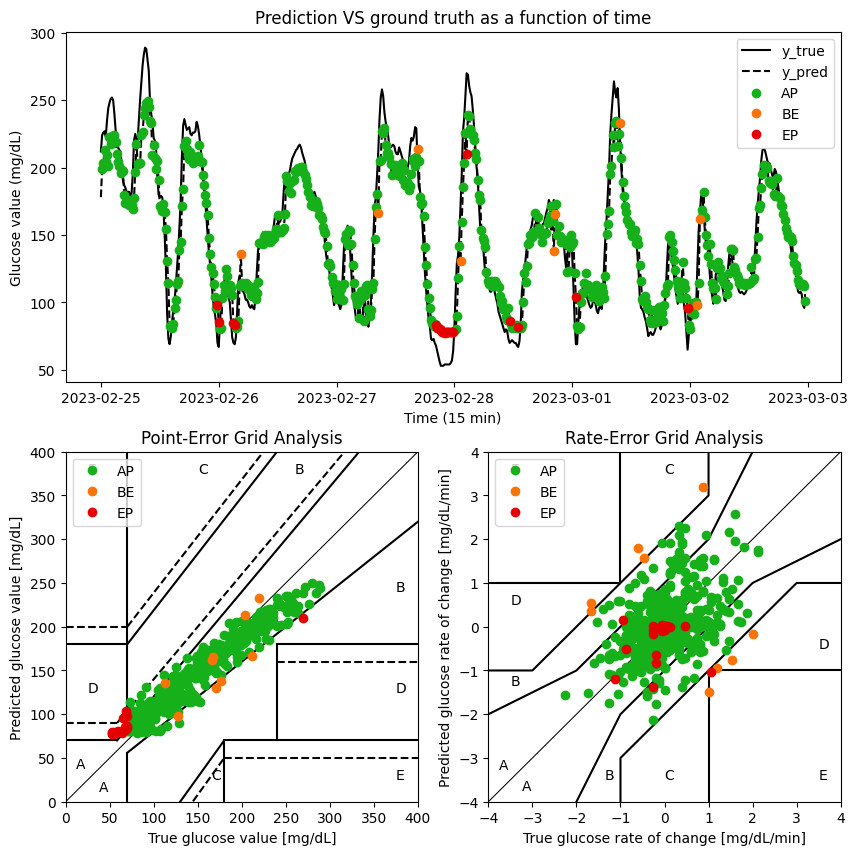

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)